In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

import finesse
from finesse.knm.tools import make_scatter_matrix
finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
k = 2*np.pi/(1064e-9)
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm

R = Lx/2 # 1 mm, we zone in to half of the size to get the activate area
w0 = R*0.1165 # The beam size 
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
print(q_0)

def fsolve_func(w0_, w_sol):
    z = Lz
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    return w-w_sol

w_lz = 85e-6
w0_s = fsolve(fsolve_func, x0=0.8*w0, args=(w_lz))
w0_l = fsolve(fsolve_func, x0=1.2*w0, args=(w_lz))
print(w0_s/w0, w0_l/w0,)

0.010018440059371258j
[0.83322281] [1.19795014]


In [3]:
(1e-2* 1064e-9/np.pi)**0.5*1e6*2**0.5

82.30209218477418

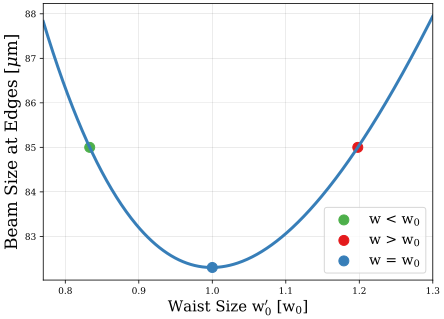

In [4]:
z = Lz
ws = []
range_ = np.linspace(0.77, 1.3, 400)
for w0_ in range_*w0: 
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    ws.append(w)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
# ax.patch.set_facecolor(background_color)

ax.plot(range_, np.array(ws)*1e6, lw=3, color=CB_color_cycle[0])

ax.scatter([w0_s/w0], [w_lz*1e6], s=100, color=CB_color_cycle[2], label="w < w$_{0}$")
ax.scatter([w0_l/w0], [w_lz*1e6], s=100, color=CB_color_cycle[7], label="w > w$_{0}$")
ax.scatter([1], [np.sqrt(1+(Lz/zR)**2)*w0*1e6], s=100, color=CB_color_cycle[0], label="w = w$_{0}$")

ax.set_xlabel(r'Waist Size w$_{0}^{\prime}$ [w$_{0}$]', fontsize=15)
ax.set_ylabel(r"Beam Size at Edges [$\mu$m]", fontsize=17)
# ax.grid();
legend = ax.legend(fontsize=14, ncols=1, loc="best");
# fig.savefig('./Beamsize_Lz.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

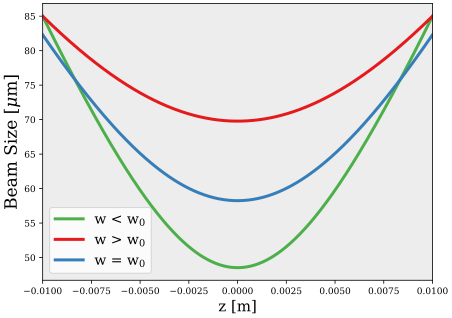

In [5]:
ws_s = []
ws_l = []
ws_0 = []
zs = np.linspace(-Lz, Lz, 400)
for z in zs:
    zR_s = np.pi*w0_s**2/(1064e-9)
    w_s = w0_s*(1+(z/zR_s)**2)**0.5
    ws_s.append(w_s)

    zR_l = np.pi*w0_l**2/(1064e-9)
    w_l = w0_l*(1+(z/zR_l)**2)**0.5
    ws_l.append(w_l)

    zR_0 = np.pi*w0**2/(1064e-9)
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_0.append(w_0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(zs, np.array(ws_s)*1e6, lw=3, color=CB_color_cycle[2], label=r"w < w$_{0}$")
ax.plot(zs, np.array(ws_l)*1e6, lw=3, color=CB_color_cycle[7], label=r"w > w$_{0}$")
ax.plot(zs, np.array(ws_0)*1e6, lw=3, color=CB_color_cycle[0], label=r"w = w$_{0}$")

ax.set_xlabel(r'z [m]', fontsize=15)
ax.set_ylabel(r"Beam Size [$\mu$m]", fontsize=17)
ax.grid();

legend = ax.legend(fontsize=14, ncols=1, loc="best");

In [6]:
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
shape = 400

Beam_0 = HGMode(q_0, n=0, m=0)
x = y = np.linspace(-R, R, shape)
xx, yy = np.meshgrid(x, y)
Beam_0_data = Beam_0.unm(x, y)

amplitude = 1e-2
phi_data = k*(xx**2 + yy**2)*amplitude 

(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)


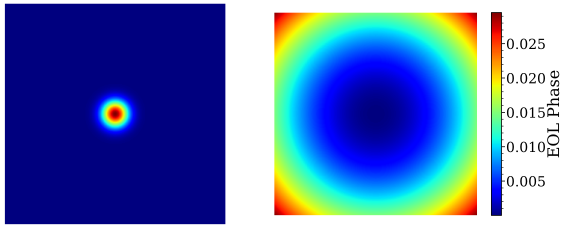

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

img1 = ax1.imshow(np.abs(Beam_0_data), cmap="jet")
img2 = ax2.imshow(phi_data, cmap="jet")
ax1.set_axis_off()
ax2.set_axis_off()

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax,)
cbar.set_label(label=r"EOL Phase", fontsize=16, rotation=90, labelpad=1)
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

In [8]:
def gouyPhase_Z_HG20(z, zR, zend):
    return (np.arctan(zend/zR) - np.arctan(z/zR))*2

In [9]:
points = [] # the center of each z slice from [-1, 1]
num = 5
step = 2/num
point = -1+step/2
points.append(point)
for i in range(num-1):
    points.append(point+step)
    point = point+step
points

[-0.8, -0.4, 0.0, 0.4, 0.8]

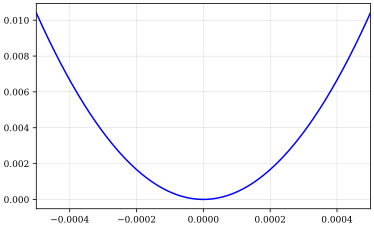

In [10]:
x = y = np.linspace(-R, R, shape)
amplitude=0.014098076265952539
phase = k*x**2*amplitude/2
plt.plot(x, phase);

In [11]:
shape = 400

def HG20_segments(w0, num=1, amplitude=0.010975376665794682, zend=Lz, extra_gouy=True):
    points = [] # the center of each z slice from [-1, 1]
    step = 2/num
    point = -1+step/2
    points.append(point)
    for i in range(num-1):
        points.append(point+step)
        point = point+step

    rho_20s = []
    gouy_phases = []
    x = y = np.linspace(-R, R, shape)
    xx, yy = np.meshgrid(x, y)

    # zstart = zend - 2*Lz # the front of the crystal, defaults to -Lz
    zR = np.pi*w0**2/(1064e-9)

    for i in range(num):
        field_point = zend - Lz + points[i]*Lz # the coordinates of the z location, defaults to [-Lz, Lz]

        q_0 = zR*1j + field_point # the beam parameter at the z location, from [-Lz, Lz]

        HG_20 = HGMode(q_0, n=2, m=0)
        HG_20_data = HG_20.unm(x, y)

        Beam_0 = HGMode(q_0, n=0, m=0)
        Beam_0_data = Beam_0.unm(x, y)

        phi_data = k*(xx**2 + yy**2)/num*amplitude/2
        # a linear map from EOBD, devided by num so the total phase shifts along the crystal for different number of z slices is fixed

        Beam_0_data_new = Beam_0_data*np.exp(1j*phi_data)

        if extra_gouy:
            gouy = gouyPhase_Z_HG20(field_point, zR, zend) # For the 2nd order modes
        else:
            gouy = 0
        gouy_phases.append(gouy)

        rho_20 = np.sum(np.conj(HG_20_data)*Beam_0_data_new)/np.sum(np.conj(HG_20_data)*HG_20_data)
        rho_20s.append(rho_20*np.exp(1j*gouy))

    return np.array(gouy_phases), np.array(rho_20s)

In [32]:
step_num = 100
Gouy_20_0, HG20_0 = HG20_segments(w0=w0, num=step_num, extra_gouy=False)
Gouy_20_s, HG20_s = HG20_segments(w0=w0_s[0], num=step_num, extra_gouy=False)
Gouy_20_l, HG20_l = HG20_segments(w0=w0_l[0], num=step_num, extra_gouy=False)

(-12.87421987457113-32.43669778042439j)
296.2238267205568
(4.207149532658195e-17-4.905077981068957e-17j)
(91.30531241036078-37.50225497040868j)
1.0
(4.207149532658195e-17-4.905077981068957e-17j)
(-12.103081303114461-32.91829928652389j)
302.23556467944604
(1.9457122009107177e-17-2.3462296134982986e-17j)
(91.95307521857286-37.221284199005545j)
1.0
(1.9457122009107177e-17-2.3462296134982986e-17j)
(-11.298797641378705-33.38808915694219j)
308.3643540595274
(8.682335837239859e-18-1.1195975929721974e-17j)
(92.60611706262928-36.925948709878355j)
1.0
(8.682335837239859e-18-1.1195975929721974e-17j)
(-10.46069760120232-33.84433487271717j)
314.6095394094367
(3.717121100246207e-18-5.320674193851526e-18j)
(93.26418617773047-36.61575009267166j)
1.0
(3.717121100246207e-18-5.320674193851526e-18j)
(-9.588168480657922-34.285192553010084j)
320.9701058868553
(1.5116275708741917e-18-2.5108665290410075e-18j)
(93.92700305256028-36.29018218813472j)
1.0
(1.5116275708741917e-18-2.5108665290410075e-18j)
(-8.68066

In [33]:
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
# background_color = '#ededed'
# ax.patch.set_facecolor(background_color)

# ax.plot(np.linspace(-1, 1, step_num), Gouy_20_s, lw=3, label="w < w$_{0}$", color=CB_color_cycle[2])
# ax.plot(np.linspace(-1, 1, step_num), Gouy_20_0, lw=3, label="w = w$_{0}$", color=CB_color_cycle[0])
# ax.plot(np.linspace(-1, 1, step_num), Gouy_20_l, lw=3, label="w > w$_{0}$", color=CB_color_cycle[7])

# ax.set_xlabel(r'Z Location [L]', fontsize=15)
# ax.set_ylabel(r"Gouy Phase", fontsize=17)
# ax.grid();
# legend = ax.legend(fontsize=16, ncols=1, loc="best");

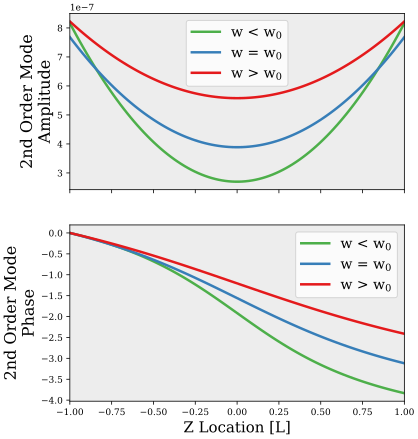

In [34]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(np.linspace(-1, 1, step_num), np.abs(HG20_s), lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")
ax.plot(np.linspace(-1, 1, step_num), np.abs(HG20_0), lw=2.5, color=CB_color_cycle[0], label="w = w$_{0}$")
ax.plot(np.linspace(-1, 1, step_num), np.abs(HG20_l), lw=2.5, color=CB_color_cycle[7], label="w > w$_{0}$")

ax1.plot(np.linspace(-1, 1, step_num), np.unwrap(np.angle(HG20_s))-np.angle(HG20_s[0]), lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")
ax1.plot(np.linspace(-1, 1, step_num), np.unwrap(np.angle(HG20_0))-np.angle(HG20_0[0]), lw=2.5, color=CB_color_cycle[0], label="w = w$_{0}$")
ax1.plot(np.linspace(-1, 1, step_num), np.unwrap(np.angle(HG20_l))-np.angle(HG20_l[0]), lw=2.5, color=CB_color_cycle[7], label="w > w$_{0}$")

ax1.set_xlabel('Z Location [L]', fontsize=15)
ax.set_ylabel('2nd Order Mode\nAmplitude', fontsize=16)
ax1.set_ylabel('2nd Order Mode\nPhase', fontsize=16)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
ax1.grid()
# ax.set_xticks(range(0, 52, 10))
# ax1.set_xticks(range(0, 52, 10))

# ax1.set_yticks([-np.pi/4, 0, np.pi/4])
# ax1.set_yticklabels(["-$\pi/4$", 0, "$\pi/4$"])

legend = ax.legend(fontsize=14, ncols=1, loc="best");
legend = ax1.legend(fontsize=14, ncols=1, loc="best");

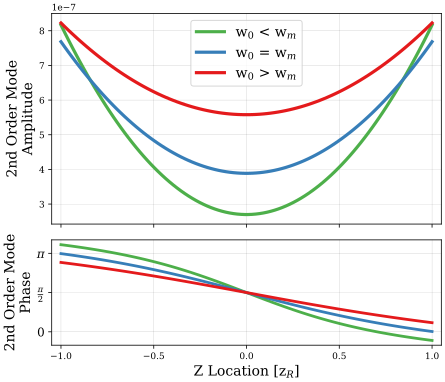

In [37]:
z_vals = np.linspace(-1, 1, step_num)
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
background_color = '#ededed'

# ax.patch.set_facecolor(background_color)
# ax1.patch.set_facecolor(background_color)

plt.subplots_adjust(hspace=0.1) 

ax.plot(z_vals, np.abs(HG20_s), lw=3.2, color=CB_color_cycle[2], label="w$_{0}$ < w$_{m}$")
ax.plot(z_vals, np.abs(HG20_0), lw=3.2, color=CB_color_cycle[0], label="w$_{0}$ = w$_{m}$")
ax.plot(z_vals, np.abs(HG20_l), lw=3.2, color=CB_color_cycle[7], label="w$_{0}$ > w$_{m}$")

ax1.plot(z_vals, np.unwrap(np.angle(HG20_s)) + 2*np.pi, lw=2.8, color=CB_color_cycle[2], label="w$_{0}$ < w$_{m}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG20_0)), lw=2.8, color=CB_color_cycle[0], label="w$_{0}$ = w$_{m}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG20_l)), lw=2.8, color=CB_color_cycle[7], label="w$_{0}$ > w$_{m}$")

ax1.set_xlabel('Z Location [z$_{R}$]', fontsize=14)
ax.set_ylabel('2nd Order Mode\nAmplitude', fontsize=14)
ax1.set_ylabel('2nd Order Mode\nPhase', fontsize=14)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax.grid()
# ax1.grid()
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlim([-1.05, 1.05])
# ax1.set_xticks(range(0, 52, 10))

ax1.set_yticks([0, np.pi/2, np.pi])
ax1.set_yticklabels([0, r"$\frac{\pi}{2}$", r"$\pi$"])

ax1.tick_params(axis='y', labelsize=12)  # Adjust the fontsize as needed for x-axis

legend = ax.legend(fontsize=14, ncols=1, loc="best");
# legend = ax1.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./Figures/2ndamp_phase.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [61]:
np.abs(HG20_0).min()*100

3.887924403922725e-05

In [59]:
w0

5.8250000000000006e-05

In [60]:
results_20_0 = []
results_20_0_abs = []
results_20_s = []
results_20_s_abs = []
results_20_l = []
results_20_l_abs = []

steps = range(1, 21)
for step in steps:
    _, HG20_0_ = HG20_segments(w0=w0, num=step, extra_gouy=False)
    _, HG20_s_ = HG20_segments(w0=w0_s[0], num=step, extra_gouy=False)
    _, HG20_l_ = HG20_segments(w0=w0_l[0], num=step, extra_gouy=False)

    results_20_0.append(HG20_0_.sum())
    results_20_0_abs.append(abs(HG20_0_).sum())

    results_20_l.append(HG20_l_.sum())
    results_20_l_abs.append(abs(HG20_l_).sum())

    results_20_s.append(HG20_s_.sum())
    results_20_s_abs.append(abs(HG20_s_).sum())

results_20_0 = np.array(results_20_0)
results_20_0_abs = np.array(results_20_0_abs)
results_20_l = np.array(results_20_l)
results_20_l_abs = np.array(results_20_l_abs)
results_20_s = np.array(results_20_s)
results_20_s_abs = np.array(results_20_s_abs)

(41.378721927245756+0j)
587.4380076995342
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(45.331124923479+0j)
847.0159178513406
(8.121457550047682e-47+0j)
(128.21578332882606+0j)
1.0
(8.121457550047682e-47+0j)
(37.80573626515034+0j)
408.73399377930974
(5.041521474810098e-23+0j)
(106.93076992335195+0j)
1.0
(5.041521474810098e-23+0j)
(15.728088990484597-35.84170440401763j)
469.8975184793713
(-9.517813844611306e-27-2.2151325944107744e-26j)
(107.75467974769238-25.39554007090398j)
1.0
(-9.517813844611306e-27-2.2151325944107744e-26j)
(15.728088990484597+35.84170440401763j)
469.8975184793713
(-9.517813844611306e-27+2.2151325944107744e-26j)
(107.75467974769238+25.39554007090398j)
1.0
(-9.517813844611306e-27+2.2151325944107744e-26j)
(0.5149825706448787-40.8443722152463j)
557.7535003869908
(4.0976247308403355e-31+1.3505479675126589e-32j)
(109.96952624018711-35.42494725689828j)
1.0
(4.0976247308403355e-31+1.3505479675126589e-32j)
(0.5149825706448787+40.8443722

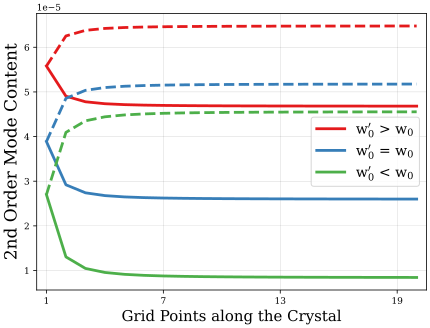

In [36]:
steps = range(1, 21)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
# ax1.patch.set_facecolor(background_color)

ax1.plot(steps, np.abs(results_20_l), lw=2.8, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax1.plot(steps, np.abs(results_20_0), lw=2.8, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax1.plot(steps, np.abs(results_20_s), lw=2.8, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")

ax1.plot(steps, np.abs(results_20_l_abs), lw=2.8, color=CB_color_cycle[7], ls="--",)
ax1.plot(steps, np.abs(results_20_0_abs), lw=2.8, color=CB_color_cycle[0], ls="--",)
ax1.plot(steps, np.abs(results_20_s_abs), lw=2.8, color=CB_color_cycle[2], ls="--",)

ax1.set_xlabel('Grid Points along the Crystal', fontsize=15)
ax1.set_ylabel(r'2nd Order Mode Content', fontsize=17)
# ax2.set_ylabel(r'$\mathrm{HG}_{1,0}$ AMP SUM', fontsize=17)

ax1.set_xlim([0.5, 20.5])

ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax2.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax1.set_xticks(range(1, 21, 6))

# ax1.grid()
legend = ax1.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./EOL_Convergence.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [37]:
np.abs(results_20_0_abs).max()

5.175389166075011e-05

In [49]:
step_num = 200
Gouy_20_0, HG20_0 = HG20_segments(w0=w0, num=step_num, extra_gouy=False)
Gouy_20_s, HG20_s = HG20_segments(w0=w0_s[0], num=step_num, extra_gouy=False)
Gouy_20_l, HG20_l = HG20_segments(w0=w0_l[0], num=step_num, extra_gouy=False)

(-13.061909075249458-32.314644490338274j)
294.73922667310694
(5.0752963542844105e-17-5.896455047766019e-17j)
(91.14422354879164-37.57031077199343j)
1.0
(5.0752963542844105e-17-5.896455047766019e-17j)
(-12.684503939157898-32.55811485913918j)
297.7157644088075
(3.480403428402871e-17-4.079930060772884e-17j)
(91.46674543247437-37.43333203040066j)
1.0
(3.480403428402871e-17-4.079930060772884e-17j)
(-12.298945925916673-32.79894098204532j)
300.72163845542775
(2.3669816744797842e-17-2.821749504668422e-17j)
(91.79063035910318-37.29285429860528j)
1.0
(2.3669816744797842e-17-2.821749504668422e-17j)
(-11.905144872380479-33.036919893758295j)
303.75680821723694
(1.59586762065341e-17-1.9505658628324785e-17j)
(92.1158501454591-37.14881634683781j)
1.0
(1.59586762065341e-17-1.9505658628324785e-17j)
(-11.503013546403112-33.2718418946394j)
306.8212130948518
(1.0661370997522325e-17-1.347467072087457e-17j)
(92.44237499858774-37.00115639146161j)
1.0
(1.0661370997522325e-17-1.347467072087457e-17j)
(-11.092467

In [18]:
np.abs(HG20_s.sum()).min()/np.abs(HG20_0.sum()).min(), np.abs(HG20_l.sum()).min()/np.abs(HG20_0.sum()).min(),

(0.32326755922334066, 1.8021688856012175)

In [12]:
step_0 = 20
results_20 = []
results_20_abs = []

results_20_0 = []
results_20_abs_0 = []

w0_evals = 1 + np.linspace(-0.2, 0.2, 100)
for w0_ in w0_evals*w0:
    _, HG20_ = HG20_segments(w0=w0_, num=step_0, extra_gouy=True)
    _, HG20_0 = HG20_segments(w0=w0_, num=step_0, extra_gouy=False)

    results_20.append(np.abs(HG20_.sum()))
    results_20_abs.append(np.abs(HG20_).sum())

    results_20_0.append(np.abs(HG20_0.sum()))
    results_20_abs_0.append(np.abs(HG20_0).sum())

results_20 = np.array(results_20)
results_20_abs = np.array(results_20_abs)

results_20_0 = np.array(results_20_0)
results_20_abs_0 = np.array(results_20_abs_0)

(-26.490944931376923-22.260976243686905j)
286.2379833400831
(-2.250897363129846e-16+5.3709887015267444e-18j)
(86.42082691564933-45.93485048031923j)
1.0
(-2.250897363129846e-16+5.3709887015267444e-18j)
(-24.221594704518168-26.49892385759856j)
332.00570359098987
(2.669330520560496e-19-6.8774126931672085e-19j)
(90.88573097030586-45.28590101918235j)
1.0
(2.669330520560496e-19-6.8774126931672085e-19j)
(-20.681767833336377-31.032588502983j)
386.8950357274711
(7.352327217406583e-22+2.3837553673066237e-22j)
(95.80159573991968-44.137408317038805j)
1.0
(7.352327217406583e-22+2.3837553673066237e-22j)
(-15.445593099789164-35.55903528979038j)
452.2075610291841
(1.1735858222669625e-25+1.8614169919990932e-25j)
(101.16356029618468-42.308684259365826j)
1.0
(1.1735858222669625e-25+1.8614169919990932e-25j)
(-8.07471547773908-39.48764945253697j)
528.5864716085346
(1.4794007547843338e-29+5.283462692543367e-30j)
(106.91067130967694-39.57160945396685j)
1.0
(1.4794007547843338e-29+5.283462692543367e-30j)
(1.7

In [13]:
w0_evals = 1 + np.linspace(-0.2, 0.2, 100)
single_inter = []
amp = 0.010975376665794682
for w0_ in w0_evals*w0:
    HG20 = k*amp*w0_**2/8*np.sqrt(2)
    single_inter.append(HG20)
np.array(single_inter).mean()
# phi_data = k*(xx**2 + yy**2)*amplitude/2

3.94041805576835e-05

In [14]:
z = Lz
ws_s = []
for w0_ in w0_evals*w0:
    zR_ = np.pi*w0_**2/(1064e-9)
    w_s = w0_*(1+(z/zR_)**2)**0.5
    ws_s.append(w_s*1e6)

In [15]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# background_color = '#ededed'
# ax1.patch.set_facecolor(background_color)
# ax2.patch.set_facecolor(background_color)
# ax3.patch.set_facecolor(background_color)
# ax4.patch.set_facecolor(background_color)
# ax1.grid()
# ax2.grid()
# ax3.grid()
# ax4.grid()
# plt.subplots_adjust(wspace=0.1, hspace=0.1) 

# ax1.plot(w0_evals, results_20_abs, label="Amplitude SUM", lw=3, color=CB_color_cycle[7],)
# ax1.plot(w0_evals, results_20, label="Complex SUM", lw=3, color=CB_color_cycle[2],)

# ax2.plot(w0_evals, results_20_abs_0, label="Amplitude SUM", ls='-', lw=3, color=CB_color_cycle[1],)
# ax2.plot(w0_evals, results_20_0, label="Complex SUM", ls='-', lw=3, color=CB_color_cycle[0],)

# ax3.plot(w0_evals, (1-results_20/results_20_abs)*100, lw=3, color=CB_color_cycle[4],)
# ax4.plot(w0_evals, (1-results_20_0/results_20_abs_0)*100, lw=3, color=CB_color_cycle[4],)

# ax4_y = ax4.twinx()

# ax4_y.plot(w0_evals, ws_s, color=CB_color_cycle[3], lw=2.8,)
# ax4_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[3], fontsize=12)
# ax4_y.tick_params('y', colors=CB_color_cycle[3])

# ax1.set_ylabel(r'Total 2nd Order Mode', fontsize=14)
# ax3.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
# ax3.set_ylabel('Phase Mismatch\nCancellation [%]', fontsize=14)

# xlabel = ax4.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
# # xlabel.set_position((1, 0))

# # ax1.set_ylim([0.3e-4, 2.3e-4])
# # ax2.set_ylim([0.3e-4, 2.3e-4])
# # ax3.set_ylim([25, 85])
# # ax3.set_yticks([25, 40, 55, 70, 85])
# # ax4.set_yticks([5, 10, 15, 20, 25])
# ax2.set_yticklabels([])

# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

# ax1.set_title("Extra Gouy Phase, $2\pi$", fontsize=14)
# ax2.set_title("No Extra Gouy Phase, $\pi$", fontsize=14)
# legend = ax1.legend(fontsize=13, ncols=1, loc="best")
# legend = ax2.legend(fontsize=13, ncols=1, loc="lower right");

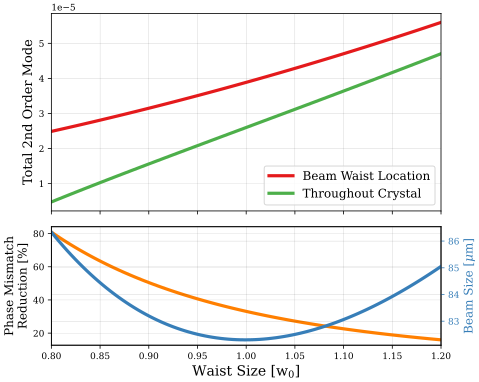

In [16]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [5, 3]})
background_color = '#ededed'
plt.subplots_adjust(hspace=-0.1) 

# ax.patch.set_facecolor(background_color)
# ax1.patch.set_facecolor(background_color)

ax.plot(w0_evals, single_inter, label="Beam Waist Location", ls='-', lw=3.2, color=CB_color_cycle[7],)
ax.plot(w0_evals, results_20_0, label="Throughout Crystal", ls='-', lw=3.2, color=CB_color_cycle[2],)
# ax.plot(w0_evals, sol_ana, label="Throughout Crystal", ls='--', lw=3.2, color=CB_color_cycle[2],)

ax1.plot(w0_evals, (1-results_20_0/single_inter)*100, lw=3.2, color=CB_color_cycle[1],)

ax1_y = ax1.twinx()

ax1_y.plot(w0_evals, ws_s, color=CB_color_cycle[0], lw=3.2,)
ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[0])

# ax.grid()
# ax1.grid()

legend = ax.legend(fontsize=12, ncols=1, loc="lower right")

plt.subplots_adjust(hspace=0.1)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[0])

ax.set_ylabel(r'Total 2nd Order Mode', fontsize=13)
ax1.set_xlabel('Waist Size [w$_{0}$]', fontsize=14)
ax1.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=12);
# fig.savefig('./Figures/EOL_Phase_Mismatch.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

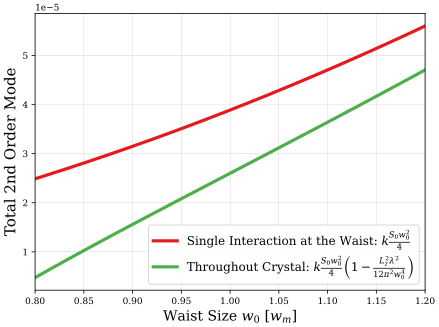

In [42]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.plot(w0_evals, single_inter, label=r"Single Interaction at the Waist: $k \frac{S_{0} w_{0}^2}{4}$", ls='-', lw=3.2, color=CB_color_cycle[7],)
ax.plot(w0_evals, results_20_0, label=r"Throughout Crystal: $k \frac{S_{0} w_0^2}{4} \left(1 - \frac{L_z^2 \lambda^2}{12 \pi^2 w_0^4} \right)$",
        ls='-', lw=3.2, color=CB_color_cycle[2],)
# ax.plot(w0_evals, sol_ana, label="Throughout Crystal", ls='--', lw=3.2, color=CB_color_cycle[2],)

# ax1.plot(w0_evals, (results_20_0/single_inter)*100, lw=3.2, color=CB_color_cycle[0],)

# ax1_y = ax1.twinx()

# ax1_y.plot(w0_evals, ws_s, color=CB_color_cycle[0], lw=3.2,)
# ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=12)
# ax1_y.tick_params('y', colors=CB_color_cycle[0])

# ax.grid()
# ax1.grid()

legend = ax.legend(fontsize=12, ncols=1, loc="lower right")

plt.subplots_adjust(hspace=0.1)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

# ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=12)
# ax1_y.tick_params('y', colors=CB_color_cycle[0])

ax.set_ylabel(r'Total 2nd Order Mode', fontsize=15)
ax.set_xlabel('Waist Size $w_{0}$ [$w_{m}$]', fontsize=14)
ax1.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=12);
# fig.savefig('./Figures/EOL_Phase_Mismatch.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [44]:
def EOL_sol(w0):
    zR = np.pi*w0**2/(1064e-9)
    return w0**2*(2*Lz - 2/(3*zR**2)*Lz**3)
    # return w0**2*2*Lz

sol_ana = EOL_sol(w0*w0_evals)
sol_ana.mean()

4.528830021632096e-11

In [61]:
# ws_s

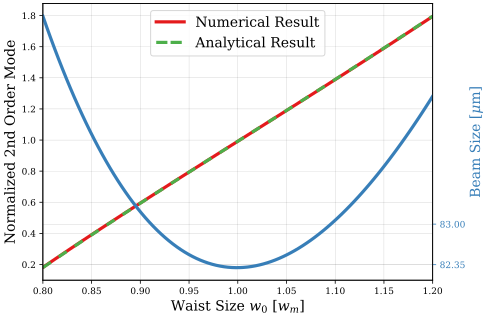

In [70]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))
background_color = '#ededed'

# ax1.patch.set_facecolor(background_color)

ax1.plot(w0_evals, results_20_0/results_20_0[50], label="Numerical Result", ls='-', lw=3.2, color=CB_color_cycle[7],)
# ax1.plot(w0_evals, sol_ana/sol_ana[50], label=r"$\mathrm{w_0^2\left(1 - \frac{L_z^2 \lambda^2}{12 \pi^2 w_0^4} \right)}$", 
#          lw=3.2, color=CB_color_cycle[2], ls="--")

ax1.plot(w0_evals, sol_ana/sol_ana[50], label=r"Analytical Result", 
         lw=3.2, color=CB_color_cycle[2], ls=(0,(3,3)))

# norm = w0_evals**2*2*Lz
# ax1.plot(w0_evals, norm/norm[50], label=r"$w_{0}^2$", 
#          lw=3, color=CB_color_cycle[1], ls="--")

ax1_y = ax1.twinx()

ax1_y.plot(w0_evals, ws_s, color=CB_color_cycle[0], lw=3.2,)
ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[0])

# ax.grid()
# ax1.grid()
plt.subplots_adjust(hspace=0.1)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[0], fontsize=14)
ax1_y.tick_params('y', colors=CB_color_cycle[0])

# ax.set_ylabel(r'Total 2nd Order Mode', fontsize=14)
ax1.set_xlabel('Waist Size $w_{0}$ [$w_{m}$]', fontsize=14)
ax1.set_ylabel('Normalized 2nd Order Mode', fontsize=14);

# ax1.set_yticks([1, 3, 5, 7, 9])
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1,4))
# ax1_y.set_yticks([82.35, 83])
legend = ax1.legend(fontsize=14, ncols=1, loc="upper center")
legend_lines = legend.get_lines()
for line in legend_lines:
    if not line.get_linestyle() == "-":
        line.set_linestyle((0, (3.5, 1)))
        
# fig.savefig('./Figures/EOL_waist_size_design.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

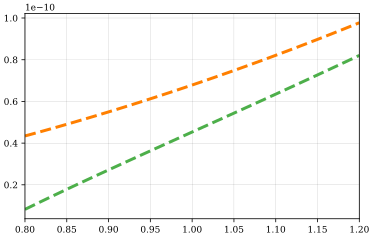

In [59]:
plt.plot(w0_evals, sol_ana, label=r"$\mathrm{w_0^2\left(L_z - \frac{L_z^3 \lambda^2}{12 \pi^2 w_0^4} \right)}$", 
         lw=3, color=CB_color_cycle[2], ls="--")

norm = w0**2*w0_evals**2*2*Lz
plt.plot(w0_evals, norm, label=r"$w_{0}^2$", 
         lw=3, color=CB_color_cycle[1], ls="--")

In [26]:
Lz**2*(1064e-9)**2/(12*np.pi**2)/w0**4, Lz

(0.08302684701466675, 0.01)

### Complete cancellation due to the phase mismatch of the 2nd order HG modes.

In [58]:
index = results_20.argmin()
w0_ = w0_evals[index]*w0
_, HG20_cancel = HG20_segments(w0=w0_, num=51, extra_gouy=True)

(-2.119087973863694-34.609261040792525j)
288.6359870006705
(-1.46669692777019e-16+7.952029376058515e-17j)
(92.8954276547267-31.444735487693006j)
1.0
(-1.46669692777019e-16+7.952029376058515e-17j)
(-0.42559091953263284-34.926845352531856j)
297.292786449991
(-3.8834486607105154e-17+4.109207279480319e-17j)
(93.8853041067805-30.75833064490123j)
1.0
(-3.8834486607105154e-17+4.109207279480319e-17j)
(1.3448391733208584-35.15776230369855j)
306.0950520674154
(-7.099899362065798e-18+1.7423909978851188e-17j)
(94.87571024224923-30.026893726665936j)
1.0
(-7.099899362065798e-18+1.7423909978851188e-17j)
(3.189222785797316-35.29179992317538j)
315.02198468086823
(2.4712669266577994e-19+6.159399896306692e-18j)
(95.86431146005131-29.24879584956283j)
1.0
(2.4712669266577994e-19+6.159399896306692e-18j)
(5.1033687199790325-35.318413699916526j)
324.0492601149178
(1.0036831333103539e-18+1.7235130992396796e-18j)
(96.8485364102978-28.422504177980542j)
1.0
(1.0036831333103539e-18+1.7235130992396796e-18j)
(7.0817

The total 2nd order mode is 2.470e-07, with a ratio of 2.265e-03


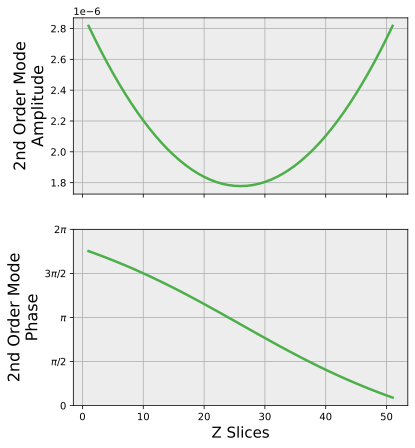

In [59]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(range(1, 52), np.abs(HG20_cancel), lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")

ax1.plot(range(1, 52), np.unwrap(np.angle(HG20_cancel))+2*np.pi, lw=2.5, color=CB_color_cycle[2], label="w < w$_{0}$")

ax1.set_xlabel('Z Slices', fontsize=15)
ax.set_ylabel('2nd Order Mode\nAmplitude', fontsize=16)
ax1.set_ylabel('2nd Order Mode\nPhase', fontsize=16)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
ax1.grid()
ax.set_xticks(range(0, 52, 10))
ax1.set_xticks(range(0, 52, 10))

ax1.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.set_yticklabels([0, "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])

print(f"The total 2nd order mode is {np.abs(HG20_cancel.sum()):.3e}, with a ratio of {np.abs(HG20_cancel.sum()) / np.abs(HG20_cancel).sum():.3e}")